# U-Net阶段性笔记与总结
提到U-Net首先就贴上架构图，一个架构图就很好的概括了U-Net中的几个关键细节了。本文围绕几个细节记录笔记，完全没有顺序性和逻辑性，基本算是想到哪写到哪了。

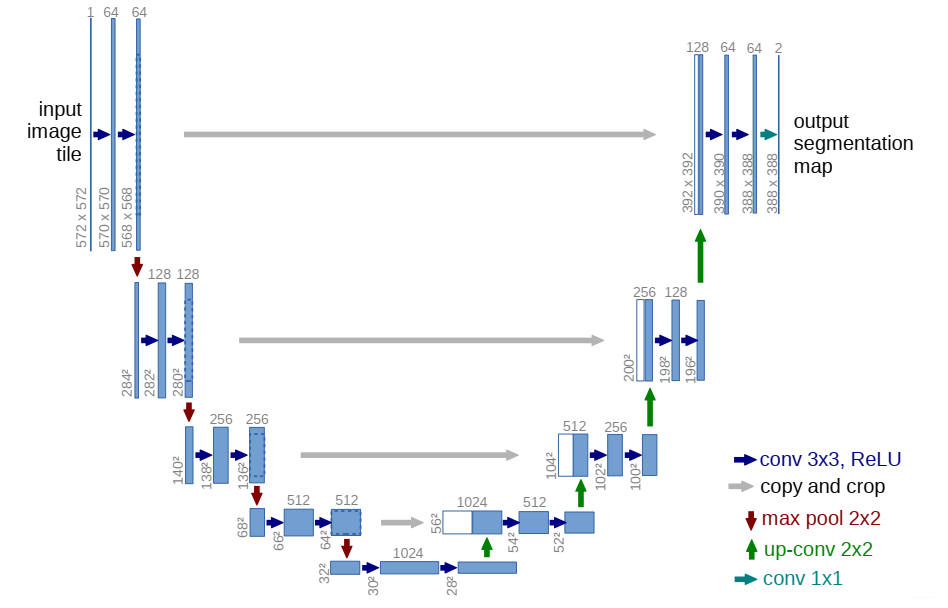

- U-Net最早就是出自2015年的MICCAI，对后来的深度学习处理医学图像分割和边缘检测做出了巨大的贡献，之后相关问题新提出的架构基本都受U-Net的影响。
- 从整体架构来看，网络结构呈u型，应该是FCN(全卷积网络)的延续，即整个网络架构没有全连接层，全部由卷积层和转置卷积层构成。由于没有全连接层，这种架构的网络参数可以做的特别小，原始的带上采样转置卷积的U-Net网络也仅有30M左右的大小，（但是这里提一下在实际操作过程中计算是比较慢的，占用显存也比通常的用于图像分类的CNN网络要多，我认为主要原因在于架构的skip connection操作要用每一次上采样后的部分做堆叠 ，内存或缓存要储存每一层的feature map作为中间值，因此消耗了内存资源。）整个u型架构结构对称，可以简单的看作编码和解码的过程，这一点与原始的FCN相比上采样过程比较缓和有一个逐渐上采样的过程，进而实现解码的过程。
- 再看到结构中的skip connection技巧，不难让我们联想到ResNet中的残差块，和GoogLeNet中的Inception块，（其中ResNet也是15年的文章，不得不说15到17年左右是深度学习各种算法爆发的时期）。其中ResNet引入的残差和跳连主要是解决了深度网络无法做深的问题（因为随着网络的加深会引入模型退化、权重衰退、模型复杂度变高等问题）ResNet着重解决了这些问题引入了非对称的残差结构，而Inception块则是在同一层添加的并行连接，在现在来看，这更像是一种多尺度的融合（同一层不同感受野的融合）。因为这里我们主要记录U-Net的笔记以上两种网络细节就不再展开。
U-Net中的skip connection在我看来主要有以下几个作用，首先伴随着特征的抽提，也就是上半部分的编码过程，数据会有大量的损失（大量的pooling层下采样）经过与未下采样的数据进行并行融合，可以一定程度的弥补损失的信息；另一方面也属于与原始信息像素级的融合，这一点让我想到了之前看到过的two-stream fusion中提到的双流融合的方法，也是有点像素级融合的意思（越往后的压缩信息损失越多），由于是像素级的对应融合，边缘信息能够很好的保留，我感觉这也是原始FCN边缘分割效果不好的原因之一；当然这种跳连结构还有其他类似结构都具有的优点，比如可以更直接的更新梯度，靠近底层的网络减少了梯度消失的危险等等。
- overlap tile技巧，通过观察网络架构不难发现最后的输出尺寸是有裁切的，也很容易想到是每层的卷积层没有padding所以没经过一次卷积就损失两行两列的边缘信息，为此，使用了overlap tile技巧，即对输入图片四个边缘进行镜像拼接，最后经过缩减的输出的mask正好是原始图片尺寸。当然也可以尝试使用padding为1的卷积，但是相应的输出图片边缘信息将会变差。
- 作者还提出了相应的对边缘信息敏感的加权的目标损失函数，由于当前任务还没用到这方面的问题，一直用交叉熵和Dice loss做的将来阅读原文献会推导并添加相关内容。
- 一些细节，在复现本架构时在上采样转置卷积中使用到的kernel=4，stride=2，padding=1的转置卷积核，这里因为上采样尺寸要扩大两倍，stride的选取没有任何异议，kernel尺寸选取stride的两倍大小表示有一定的重叠的量，上采样不会太生硬。此外在ReLU之前添加了BN层。
- 另外，一些常见的U-Net的魔改版，如缩减卷积的通道数量；更换其他有名的特征提取层；尝试在不同尺度进行融合和预测等等。
- 在复现期间遇到的问题，比如我使用的pytorch平台，在构建网络的过程中由于继承的nn.Module类，在模型初始化的过程中把重复的步骤都用for loop写在一个字典中了，只有在def forward中自定义的运算过程，这导致模型在更新梯度的过程中仅仅更新了在def __init__中声明的层，而重复的卷积层一直都是随机初始化的状态。这说明对面对对象使用的还是不够透彻，后期经过修改，对重复的层单独继承Module类，在U-Net网络初始化的过程中将所有层声明在init中，经过修改实现了实验效果。
- 关于U-Net++模型，该模型是18年提出的网络，是对U-Net网络的超级魔改版本，其文章作者也写过对U-Net++模型的解读文章，内容很详细且通俗易懂，这里就不展开了，在此贴上[链接](https://zhuanlan.zhihu.com/p/44958351)。作者主要写了其思考过程，如何一步一步设计的该模型，对宏观的学习很有帮助。